## Analyse af lager vs realisationsbeskatning ved forskellige depotstørrelser

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/jovyan/work/dkfinance_modeller'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dkfinance_modeller.aktieskat.depotmodel as depotmodel
import dkfinance_modeller.aktieskat.kurtage as kurtage
import dkfinance_modeller.aktieskat.skat as skat
import dkfinance_modeller.aktieskat.vaerdipapirer as værdipapirer
import dkfinance_modeller.aktieskat.valuta as valuta
import dkfinance_modeller.simple_modeller.formler as formler

Opsætning af depoter

In [4]:

def depoter(kapital : float) -> Tuple[depotmodel.DepotModel, depotmodel.DepotModel]:
    """Definere depoter.

    Returns:
      Depot med realationsbeskatning
    """
    etf1 = værdipapirer.ETF(kurs=100, åop=0.12 / 100)
    etf2 = værdipapirer.ETF(kurs=100, åop=0.55 / 100)
    lagerbeskatning = depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="euro", valutakurs=7.44, underkonto=True),
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="lager",
        ETFer=[etf1],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    )
    realisationsbeskatning = depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="Dkk"),
        skattefunktion=skat.aktiebeskatning,
        minimumskøb=5000,
        beskatningstype="realisation",
        ETFer=[etf2],
        ETF_fordeling=[1.0],
    )
    return lagerbeskatning, realisationsbeskatning

Beregning af slutværdi

In [5]:
data = np.genfromtxt("../SP500.csv", delimiter=";")
real: List[List[float]] = [[], [], [], []]
lager: List[List[float]] = [[], [], [], []]
out = pd.DataFrame({'kapital': pd.Series([], dtype='float64'),
                   'periode': pd.Series([], dtype='category'),
                   'start': pd.Series([], dtype='int64'),
                   'type': pd.Series([], dtype='category'),
                   'salgsværdi': pd.Series([], dtype='float64')})
for kapital in [50000, 100000,150000,200000,  300000, 1000000 ]:
    for j, antal_år in enumerate([1, 5, 10, 20]):
        for start in range(0, len(data) - 950 - antal_år * 12):
            lagerdepot, realisationsdepot = depoter(kapital)
            udbytte_årlig = 0.0
            kursstigning_årlig = 0.0
            for i in range(start + 950, start + 950 + 12 * antal_år):
                udbytteafkast_real = realisationsdepot.ETFer[0].kurs * data[i + 1, 4]
                kursafkast_real = realisationsdepot.ETFer[0].kurs * data[i + 1, 3]
                udbytteafkast_lager = lagerdepot.ETFer[0].kurs * data[i + 1, 4]
                kursafkast_lager = lagerdepot.ETFer[0].kurs * data[i + 1, 3]
                if i % 12 == 0:
                    effektivt_udbytte = udbytte_årlig + max(0, 0.3 * kursstigning_årlig)
                    realisationsdepot.afkast_månedlig(
                        [udbytteafkast_real + kursafkast_real - effektivt_udbytte], [effektivt_udbytte]
                    )
                    udbytte_årlig = 0.0
                    kursstigning_årlig = 0.0
                else:
                    realisationsdepot.afkast_månedlig([udbytteafkast_real + kursafkast_real], [0.0])
                lagerdepot.afkast_månedlig([udbytteafkast_lager + kursafkast_lager], [0.0])
                udbytte_årlig += udbytteafkast_real
                kursstigning_årlig += kursafkast_real
            out = out.append(pd.DataFrame({'kapital': pd.Series([kapital, kapital], dtype='float64'),
                                    'periode': pd.Series([antal_år, antal_år], dtype='category'),
                                    'start': pd.Series([start, start], dtype='int64'),
                                    'type': pd.Series(['real', 'lager'], dtype='category'),
                                    'salgsværdi': pd.Series([realisationsdepot.total_salgsværdi(), lagerdepot.total_salgsværdi()], dtype='float64')}))

out['CAGR'] = ((out['salgsværdi']/out['kapital'])**(1/out['periode']) -1).astype(float)
out2 = out.set_index(['kapital', 'periode', 'start', 'type'])

Varians i årligt afkast 

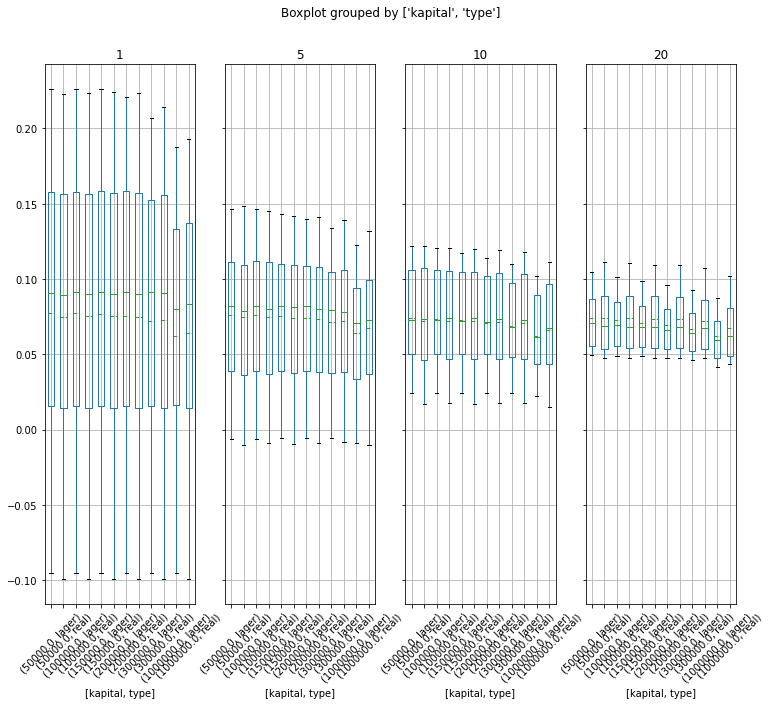

In [14]:
boxplt = out2[['CAGR']].groupby(['periode']).boxplot(by = ['kapital','type'], figsize = [12,10], sym = '', rot='45', whis = [10, 90], meanline = True, showmeans = True, layout = (1,4))

Forskel i årligt afkast mellem lager og realisationsbeskattet depot opdelt i percentiler.

Generelt er realisationsbeskatning mere aggressiv grundet den effektive gearing, så både højere downside og upside.

For store depoter hvor progressionsgrænsen alligevel rammes for lagerdepotet har realisationsbeskatning klar fordel. 

Det modsatte er gældende ved mindre depoter hvor realisationsbeskatning i højere grad vil ramme den høje skattesats. Det kunne være interessant at indføre en form for skatteoptimering til nedsparing.

/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


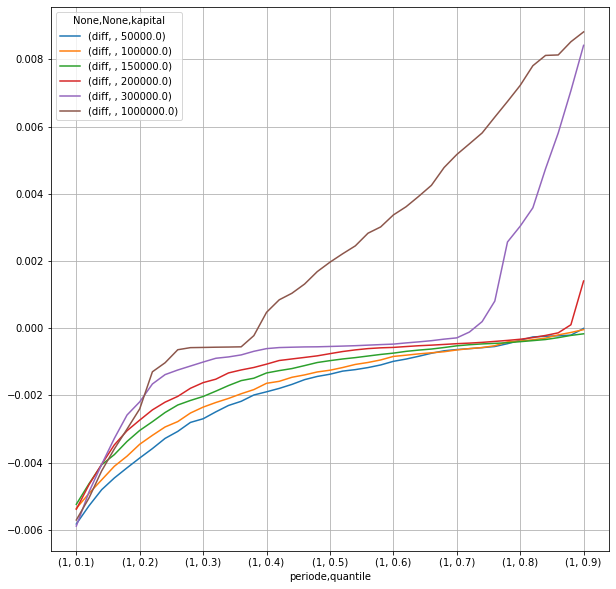

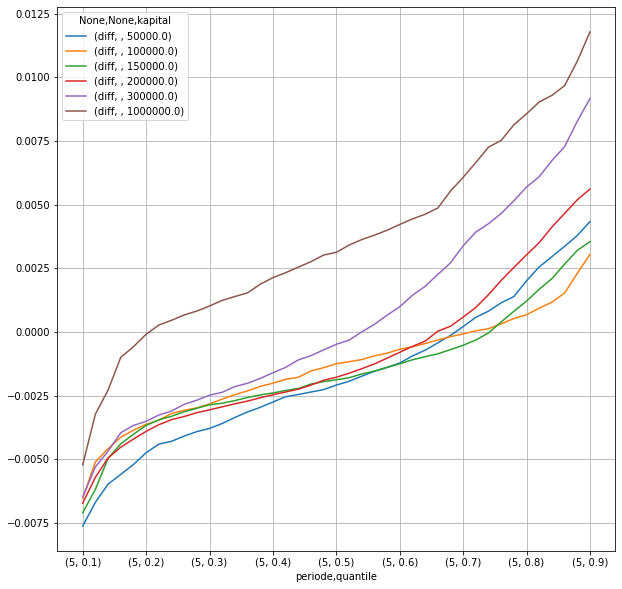

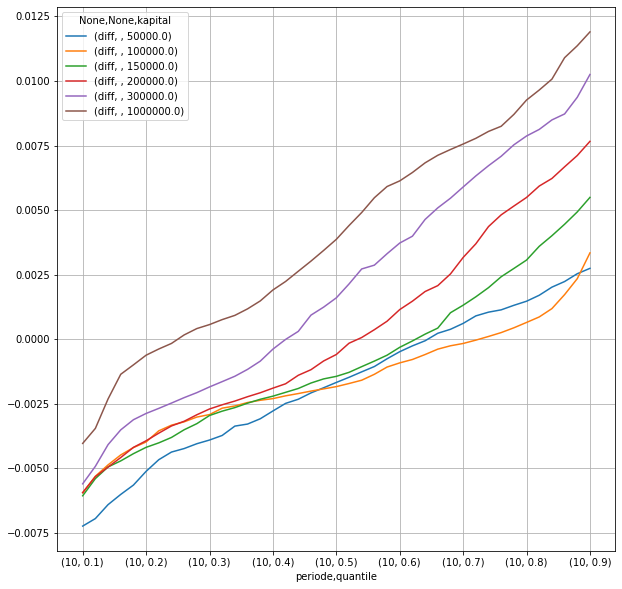

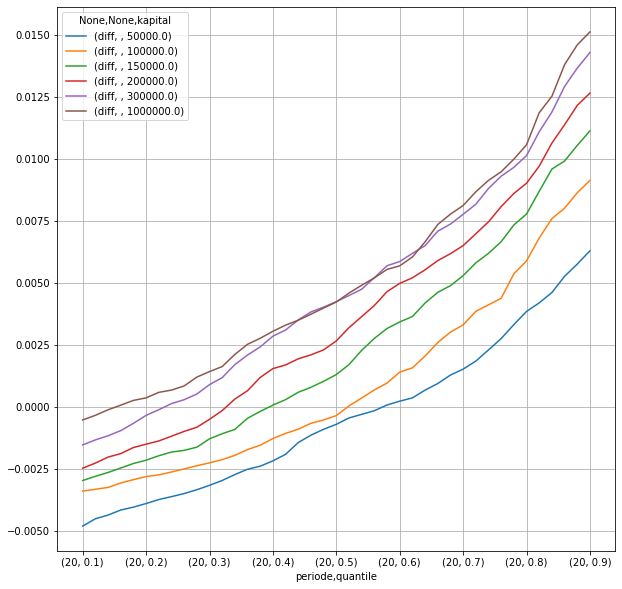

In [7]:
var = out2[['CAGR']].unstack('type')
var['diff'] = var['CAGR','real'] - var['CAGR','lager']
var = var[['diff']].groupby(['kapital', 'periode']).quantile(np.linspace(0.1,0.9,num=41).round(2))
var.index.names = ['kapital', 'periode', 'quantile']
varplt = var.unstack('kapital').groupby('periode').plot(by = 'quantile', grid=True, figsize = [10,10], layout = (1,4)) #BEST SO FAR